In [18]:
from openai import OpenAI

# Initialize the client with the API key
client = OpenAI(api_key="INSERT YOUR KEY")

# Retrieve the list of models
models_response = client.models.list()

# Print each model's details line by line
for model in models_response.data:
    print(f"Model ID: {model.id}")
    print(f"Created: {model.created}")
    print(f"Object: {model.object}")
    print(f"Owned by: {model.owned_by}")
    print("-" * 40)


Model ID: gpt-4o-mini-transcribe
Created: 1742068596
Object: model
Owned by: system
----------------------------------------
Model ID: gpt-4o-audio-preview-2024-12-17
Created: 1734034239
Object: model
Owned by: system
----------------------------------------
Model ID: dall-e-3
Created: 1698785189
Object: model
Owned by: system
----------------------------------------
Model ID: dall-e-2
Created: 1698798177
Object: model
Owned by: system
----------------------------------------
Model ID: gpt-4o-audio-preview-2024-10-01
Created: 1727389042
Object: model
Owned by: system
----------------------------------------
Model ID: omni-moderation-latest
Created: 1731689265
Object: model
Owned by: system
----------------------------------------
Model ID: omni-moderation-2024-09-26
Created: 1732734466
Object: model
Owned by: system
----------------------------------------
Model ID: gpt-4o-realtime-preview-2024-10-01
Created: 1727131766
Object: model
Owned by: system
-----------------------------------

In [43]:
from openai import OpenAI
import pandas as pd
import json
import time

# Initialize the OpenAI client
client = OpenAI(api_key="INSERT YOUR KEY")

# Load the Excel file
df = pd.read_excel("Phase1.xlsx")

def get_decision_for_row(row, row_index):
    # Construct study details string
    study_details = (
        f"Title: {row['title']}\n"
        f"Abstract: {row['abstract']}\n"
        f"Publication Year: {row['publication_year']}\n"
        f"Journal Name: {row['journal_name']}\n"
        f"Author: {row['author']}\n"
        f"Author Affiliation: {row['author_affiliation']}\n"
        f"Keywords: {row['keywords']}"
    )

    # Prompt with clear instructions
    prompt = f"""
You are an expert reviewer for research studies. Based on the study details below and the eligibility criteria provided, decide if the study should be included.

Study Details:
{study_details}

Eligibility Criteria:
1. Original or Empirical Research: The study is based on direct observation and measurement using primary data. Editorials, letters, protocols, etc. are not considered.
2. Publication Date: The study was published in 2008 or later.
3. Target Population (Age): The study focuses on youth between 13 and 25.
4. Target Population (Homelessness): The study focuses on youth who are homeless, unstably housed, or at risk (including those who have run away or are currently homeless).
5. Geographical Scope: The study was conducted in an OECD country.
6. Study Focus: The study describes a program, service, or intervention related to youth homelessness.
7. Effectiveness Reporting: The study reports the effectiveness of such a program, service, or intervention.
8. Implementation Reporting: The study reports on the implementation of such a program, service, or intervention.

Instructions:
- Return a JSON object with two keys: "Decision" and "Explanation".
- "Decision" must be one of "Include", "Exclude", or "Maybe".
- If "Exclude", use one or more of: X-0, X-1, X-2, X-3, X-4, X-5, X-6a, X-6b.
- If "Maybe", provide a short explanation (max 20 words).
- If "Include", explanation can be "N/A".

Return only the JSON object. No extra text.
"""

    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "You are an expert reviewer."},
                {"role": "user", "content": prompt}
            ],
            temperature=0
        )

        reply = response.choices[0].message.content.strip()
        print(f"\nRow {row_index + 1} - Raw GPT reply:\n{reply[:500]}")

        # Clean markdown-style wrapping if GPT uses backticks
        if reply.startswith("```json"):
            reply = reply.replace("```json", "").strip("` \n")
        elif reply.startswith("```"):
            reply = reply.strip("` \n")

        # Try parsing cleaned response
        try:
            result = json.loads(reply)
            return result.get("Decision", "Maybe"), result.get("Explanation", "")
        except json.JSONDecodeError:
            print(f"⚠️ Could not parse JSON on row {row_index + 1}")
            print("Full GPT reply:\n", reply)
            return "Maybe", "Could not parse JSON: GPT returned non-JSON content"

    except Exception as e:
        print(f"❌ Error processing row {row_index + 1}: {e}")
        return "Maybe", "API call failed"

# Main processing loop
decisions = []
explanations = []

for i, row in df.iterrows():
    decision, explanation = get_decision_for_row(row, i)
    decisions.append(decision)
    explanations.append(explanation)
    time.sleep(1)  # Respectful delay to avoid rate limits

# Add new columns to the DataFrame
df["Decision"] = decisions
df["Explanation"] = explanations

# Save the updated dataset
output_path = "Phase1_with_decisions.xlsx"
df.to_excel(output_path, index=False)
print(f"\n✅ Processing complete. Output saved to {output_path}")



Row 1 - Raw GPT reply:
```json
{
  "Decision": "Include",
  "Explanation": "N/A"
}
```

Row 2 - Raw GPT reply:
```json
{
  "Decision": "Include",
  "Explanation": "N/A"
}
```

Row 3 - Raw GPT reply:
```json
{
  "Decision": "Exclude",
  "Explanation": "X-1"
}
```

Row 4 - Raw GPT reply:
```json
{
  "Decision": "Include",
  "Explanation": "N/A"
}
```

Row 5 - Raw GPT reply:
```json
{
    "Decision": "Include",
    "Explanation": "N/A"
}
```

Row 6 - Raw GPT reply:
```json
{
  "Decision": "Exclude",
  "Explanation": "X-1, X-3, X-4, X-6a, X-6b"
}
```

Row 7 - Raw GPT reply:
```json
{
    "Decision": "Exclude",
    "Explanation": "X-1, X-3, X-5, X-6a, X-6b"
}
```

Row 8 - Raw GPT reply:
```json
{
  "Decision": "Exclude",
  "Explanation": "X-0, X-6a, X-6b, X-7, X-8"
}
```

Row 9 - Raw GPT reply:
```json
{
    "Decision": "Exclude",
    "Explanation": "X-3"
}
```

Row 10 - Raw GPT reply:
```json
{
  "Decision": "Exclude",
  "Explanation": "X-0, X-1, X-6a, X-6b"
}
```

Row 11 - Raw GPT reply:

In [47]:
import pandas as pd

# Load the two datasets
df1 = pd.read_excel("Phase1_with_decisions.xlsx")
df2 = pd.read_excel("Phase1_with_humans.xlsx")

# Define the shared columns to merge on
shared_columns = [
    "title", 
    "publication_year", 
    "abstract", 
    "journal_name", 
    "author", 
    "author_affiliation", 
    "keywords"
]

# Perform the merge
merged_df = pd.merge(df1, df2, on=shared_columns, how="outer", suffixes=("_GPT", "_Human"))

# Save to a new Excel file
merged_df.to_excel("Phase1_merged.xlsx", index=False)

print("✅ Merging complete. Output saved to Phase1_merged.xlsx")


✅ Merging complete. Output saved to Phase1_merged.xlsx


In [49]:


# Load the merged Excel file
merged_df = pd.read_excel("Phase1_merged.xlsx")



In [61]:
merged_df

,title,publication_year,abstract,journal_name,publisher_GPT,author,author_affiliation,keywords,Decision,Explanation,publisher_Human,notes,is.included,inclusion_label1,inclusion_label2,exclusion_label1,exclusion_label2,exclusion_label3,Decision_binary
0,"""Bad Things Could Happen"": How Fear Impedes So...",2008.0,"In this study, I compared the shifts in attitu...",Journal of adolescent research,NaN,Scott Seider,Boston University,"social responsibility, emerging adulthood, pri...",Exclude,"X-4, X-6a, X-6b",NaN,"<p>RAYYAN-INCLUSION: {""Shannon""=>false, ""Alexa...",0,NaN,NaN,"The study does not describe a program, service...",NaN,NaN,0
1,"""Children Of The Street"": Sexual Citizenship A...",2012.0,Youth-sensitive policies are gradually gaining...,Comparative Education,NaN,Georgina Yaa Oduro,"University of Cape Coast, Ghana",NaN,Exclude,X-5,NaN,"<p>RAYYAN-INCLUSION: {""Shannon""=>false, ""Alexa...",0,NaN,NaN,The study was not conducted in an OECD country,NaN,NaN,0
2,"""Housing First"" For Homeless Youth With Mental...",2016.0,"""Housing First"" has been shown to improve hous...",Pediatrics (Evanston),United States: American Academy of Pediatrics,Nicole Kozloff; Carol E. Adair; Luis I. Palma ...,"Centre for Urban Health Solutions, Li Ka Shing...","homeless youth, housing, mental disorders, sta...",Include,NaN,United States: American Academy of Pediatrics,"RAYYAN-INCLUSION: {""Shannon""=>true, ""Reiko""=>t...",1,NaN,NaN,NaN,NaN,NaN,1
3,"""I Don't Want To Live Like This Anymore"": Disr...",2013.0,This article reports on interview data gathere...,Youth & Society,NaN,"Tony Gilbert, Paul Farrand, Gloria Lankshear","School of Social Science and Social Work, Facu...","Bourdieu, crisis, personality disorder, self-h...",Exclude,"X-6a, X-6b",NaN,"<p>RAYYAN-INCLUSION: {""Shannon""=>false, ""Alexa...",0,NaN,NaN,The target population is not homeless or unsta...,NaN,NaN,0
4,"""It's Good To Have Wheels!"" Perceptions Of Cyc...",2012.0,Participation in sporting or recreational prog...,Youth Studies Australia,NaN,"Belinda Crawford, Christopher Rissel, Rowena Y...",University of New South Wales; University of S...,"cycling, among, homeless, young, people, sydne...",Exclude,"X-6a, X-6b, X-7, X-8",NaN,"<p>RAYYAN-INCLUSION: {""Shannon""=>false, ""Alexa...",0,NaN,NaN,"The study does not describe a program, service...",NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457,Youth Perspectives On Sexual Health Workshops:...,2015.0,Newcomer and street-involved youth provided th...,Qualitative health research,NaN,"Heather Ashdown, Chelsea Jalloh, John L. Wylie","University of Manitoba, Winnipeg, Manitoba, Ca...",adolescents / youth; at-risk; focus groups; he...,Exclude,"X-6a, X-7, X-8",NaN,"RAYYAN-INCLUSION: {""Shannon""=>true, ""Reiko""=>t...",1,Background,Need more information,"The study does not describe a program, service...",NaN,NaN,0
458,"Youth, Musical Education And Media: Singularit...",2011.0,The place of popular and multifunctional media...,"Action, criticism, & theory for music education",NaN,Jusamara Souza,"Federal University of Rio Grande do Sul, Brazil",NaN,Exclude,"X-1, X-3, X-4, X-6a, X-6b",NaN,"<p>RAYYAN-INCLUSION: {""Shannon""=>false, ""Alexa...",0,NaN,NaN,The target population is not homeless or unsta...,NaN,NaN,0
459,Youth-Adult Connectedness:: A Key Protective F...,2017.0,"Over the past 30 years, prevention science in ...",American journal of preventive medicine,Netherlands: Elsevier Science Ltd,"Renee E. Sieving, Annie-Laurie McRee, Barbara ...",Healthy Youth Development–Prevention Research ...,NaN,Exclude,"X-6a, X-6b",Netherlands: Elsevier Science Ltd,"RAYYAN-INCLUSION: {""Shannon""=>true, ""Reiko""=>t...",1,Review References,Need more information,NaN,NaN,NaN,0
460,Youthbuild. What Works Clearinghouse Intervent...,2009.0,NaN,NaN,NaN,NaN,NaN,NaN,Exclude,"X-0, X-3, X-4, X-5, X-6a, X-6b",NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,0


In [53]:
merged_df['Decision'].value_counts()

Decision
Exclude    417
Include     44
Maybe        1
Name: count, dtype: int64

In [55]:
#For now recode maybe to be 1
merged_df['Decision_binary'] = merged_df['Decision'].replace({
    'Exclude': 0,
    'Include': 1,
    'Maybe': 1
})



/var/folders/6l/_j3ymxdx3bndlj9z22_9d6000000gp/T/ipykernel_98883/2157853172.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df['Decision_binary'] = merged_df['Decision'].replace({


In [57]:
merged_df['Decision_binary'].value_counts()

Decision_binary
0    417
1     45
Name: count, dtype: int64

In [63]:
merged_df['is.included'].value_counts()

is.included
0    262
1    200
Name: count, dtype: int64

In [67]:
#Structured classification prompt

from openai import OpenAI
import pandas as pd
import json
import time

# Initialize the OpenAI client
client = OpenAI(api_key="INSERT YOUR KEY")

# Load the Excel file
df = pd.read_excel("Phase1.xlsx")

def get_decision_for_row(row, row_index):
    study_details = (
        f"Title: {row['title']}\n"
        f"Abstract: {row['abstract']}\n"
        f"Publication Year: {row['publication_year']}\n"
        f"Journal Name: {row['journal_name']}\n"
        f"Author: {row['author']}\n"
        f"Author Affiliation: {row['author_affiliation']}\n"
        f"Keywords: {row['keywords']}"
    )

    prompt = f"""
You are an expert reviewer for research studies. Based on the study details below and the eligibility criteria provided, decide if the study should be included.

Study Details:
{study_details}

Eligibility Criteria:
1. Original or Empirical Research: The study is based on direct observation and measurement using primary data. Editorials, letters, protocols, etc. are not considered.
2. Publication Date: The study was published in 2008 or later.
3. Target Population (Age): The study focuses on youth between 13 and 25.
4. Target Population (Homelessness): The study focuses on youth who are homeless, unstably housed, or at risk (including those who have run away or are currently homeless).
5. Geographical Scope: The study was conducted in an OECD country.
6. Study Focus: The study describes a program, service, or intervention related to youth homelessness.
7. Effectiveness Reporting: The study reports the effectiveness of such a program, service, or intervention.
8. Implementation Reporting: The study reports on the implementation of such a program, service, or intervention.

Exclusion Codes:
- X-0: Not original/empirical research
- X-1: Published before 2008
- X-2: Target population is not youth (outside 13–25 age range)
- X-3: Population is not homeless or at risk of homelessness
- X-4: Not conducted in an OECD country
- X-5: Does not describe a program/service/intervention
- X-6a: Does not report effectiveness
- X-6b: Does not report implementation

Instructions:
Evaluate each criterion and return:
1. "Criteria_Results": a list of 8 answers ("Yes" or "No (X-code)")
2. "Decision": "Include" if all criteria are "Yes", "Exclude" if any are "No", or "Maybe" if unclear
3. "Explanation": "N/A" for Include, list of codes for Exclude, or short note (max 20 words) for Maybe

Return only the JSON object. No extra commentary.
"""

    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "You are an expert reviewer."},
                {"role": "user", "content": prompt}
            ],
            temperature=0
        )

        reply = response.choices[0].message.content.strip()

        # Clean markdown-style backtick wrappers
        if reply.startswith("```json"):
            reply = reply.replace("```json", "").strip("` \n")
        elif reply.startswith("```"):
            reply = reply.strip("` \n")

        try:
            result = json.loads(reply)
            return (
                result.get("Decision", "Maybe"),
                result.get("Explanation", ""),
                result.get("Criteria_Results", [])
            )
        except json.JSONDecodeError:
            print(f"⚠️ JSON parse error on row {row_index + 1}")
            print("GPT Reply:\n", reply)
            return "Maybe", "Parse error", []

    except Exception as e:
        print(f"❌ Error on row {row_index + 1}: {e}")
        return "Maybe", "API error", []

# Process all rows
decisions = []
explanations = []
criteria_logs = []

for i, row in df.iterrows():
    decision, explanation, criteria = get_decision_for_row(row, i)
    decisions.append(decision)
    explanations.append(explanation)
    criteria_logs.append(str(criteria))
    time.sleep(1)  # To respect API rate limits

# Add results to DataFrame
df["Decision"] = decisions
df["Explanation"] = explanations
df["Criteria_Results"] = criteria_logs

# Save the results
output_path = "Phase1_with_decisions_detailed.xlsx"
df.to_excel(output_path, index=False)
print(f"\n✅ Processing complete. File saved to: {output_path}")



✅ Processing complete. File saved to: Phase1_with_decisions_detailed.xlsx


In [69]:


# Load the merged Excel file
data = pd.read_excel("Phase1_with_decisions_detailed.xlsx")



In [71]:
data['Decision'].value_counts()

Decision
Exclude    445
Include     15
Name: count, dtype: int64

In [ ]:
data['Decision_binary'] = data['Decision'].replace({
    'Exclude': 0,
    'Include': 1,
    'Maybe': 1
})


In [108]:
#Structured classification prompt with rule-based reasoning with flexibility to decrease false negative rates
#isn’t classic CoT because it doesn’t demand explicit step-by-step reasoning in the response.
#Temperature 0

from openai import OpenAI
import pandas as pd
import json
import time

# Initialize the OpenAI client 
client = OpenAI(api_key="INSERT YOUR KEY")

# Load the Excel file
df = pd.read_excel("Phase1.xlsx")

def get_decision_for_row(row, row_index):
    study_details = (
        f"Title: {row['title']}\n"
        f"Abstract: {row['abstract']}\n"
        f"Publication Year: {row['publication_year']}\n"
        f"Journal Name: {row['journal_name']}\n"
        f"Author: {row['author']}\n"
        f"Author Affiliation: {row['author_affiliation']}\n"
        f"Keywords: {row['keywords']}"
    )
    
    prompt = f"""
    You are an expert reviewer for research studies with human-like reasoning. Your goal is to identify empirical studies about youth homelessness interventions that should be considered for inclusion. Based on the study details below, the tnterpretation guidance, and the eligibility criteria, decide if the study should be included. Use contextual inference to reduce false negatives (e.g., lean toward 'Yes' when ambiguous but not definitively 'No'). 

    Study Details: {study_details}

    Interpretation Guidance:
    - If a study uses terms like "youth," "adolescents," or "young people," assume the target age is 13–25 unless contradicted.
    - Use 'Publication Year' from the study details as the definitive publication date, ignoring earlier years mentioned in the abstract (e.g., data collection years).
    - If a country isn’t mentioned, assume OECD unless evidence suggests otherwise.
    - If a program/intervention is described with outcomes (e.g., reduced substance use, test scores), assume effectiveness is reported.
    - If the study discusses how the intervention was applied, implemented, or delivered, assume it reports on implementation. To further explain, if the study describes assignment to interventions, group comparisons (e.g., treatment vs. control), or engagement/process details, assume implementation is reported.
    - When eligibility is unclear but aligns with the review’s goal (youth homelessness interventions), lean toward inclusion.


    Eligibility Criteria:
    1. Original or Empirical Research: The study is based on observation and measurement of phenomena using primary data. Secondary data may form the theoretical background. Editorials, letters, and protocols are not included.
    2. Publication Date: Published in 2008 or later.
    3. Target Population (Age): Focuses on youth aged 13–25 (infer from relevant words such as "youth," "adolescents," "young people", etc.).
    4. Target Population (Homelessness): Focuses on youth who are homeless, unstably housed, or at risk of homelessness, including those who: a) are unstably housed, b) have run away from home, c) are currently homeless, or d) are at risk of homelessness (infer from related terms like 'runaway' or 'housing instability').
    5. Geographical Scope: Conducted in an OECD country. OECD countries are: Australia, Austria, Belgium, Canada, Chile, Colombia, Czech Republic, Denmark, Estonia, Finland, France, Germany, Greece, Hungary, Iceland, Ireland, Israel, Italy, Japan, Korea, Latvia, Lithuania, Luxembourg, Mexico, Netherlands, New Zealand, Norway, Poland, Portugal, Slovak Republic, Slovenia, Spain, Sweden, Switzerland, Turkey, United Kingdom, United States (infer from country names, author affiliation, or journal if not explicit. If  If a country is not mentioned, assume it is in the OECD.).
    6. Study Focus: Describes a program, service, or intervention related to youth homelessness (infer from context if not explicit).
    7. Effectiveness Reporting: Reports effectiveness of the program, service, or intervention (infer from outcomes or results if 'effectiveness' isn’t explicit).
    8. Implementation Reporting: Reports implementation of the program, service, or intervention (infer from process descriptions, such as assignment, group design, or process details, if 'implementation' isn’t explicit).

    Exclusion Codes:
    - X-0: Not original/empirical research
    - X-1: Published before 2018
    - X-2: Target population not youth (outside 13–25)
    - X-3: Population not homeless/at risk
    - X-4: Not in an OECD country
    - X-5: No program/service/intervention
    - X-6a: No effectiveness reported
    - X-6b: No implementation reported

    Instructions:
    - Evaluate each criterion holistically, inferring where reasonable (e.g., 'youth' = 13–25).
    - Prioritize 'Publication Year' from study details for criterion 2.
    - Lean toward 'Yes' when a criterion is ambiguous but not definitively unmet, especially for criteria 7 and 8, to reduce false negatives.
    - Return:
      1. "Criteria_Results": List of 8 answers ("Yes" or "No (X-code)")
      2. "Decision": "Yes" if all criteria are "Yes", "No" if any are "No"
      3. "Explanation": "N/A" for Yes, list of codes for No
    - Return only the JSON object.
    """

    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "You are an expert reviewer with human-like reasoning."},
                {"role": "user", "content": prompt}
            ],
            temperature=0  # Could be slightly higher for flexibility while maintaining consistency
        )
        reply = response.choices[0].message.content.strip()
        # Clean markdown-style backticks
        if reply.startswith("```json"):
            reply = reply.replace("```json", "").strip("` \n")
        elif reply.startswith("```"):
            reply = reply.strip("` \n")
        
        try:
            result = json.loads(reply)
            return (
                result.get("Decision", "No"),  # Default to "No" if parsing fails
                result.get("Explanation", "Parse error"),
                result.get("Criteria_Results", [])
            )
        except json.JSONDecodeError:
            print(f"⚠️ JSON parse error on row {row_index + 1}")
            print("GPT Reply:\n", reply)
            return "No", "Parse error", []
    except Exception as e:
        print(f"❌ Error on row {row_index + 1}: {e}")
        return "No", "API error", []

# Process all rows
decisions = []
explanations = []
criteria_logs = []
for i, row in df.iterrows():
    decision, explanation, criteria = get_decision_for_row(row, i)
    decisions.append(decision)
    explanations.append(explanation)
    criteria_logs.append(str(criteria))
    time.sleep(1)  # Respect API rate limits

# Add results to DataFrame
df["Decision"] = decisions
df["Explanation"] = explanations
df["Criteria_Results"] = criteria_logs

# Save the results
output_path = "Phase1_with_FNreduction_temp0.xlsx"
df.to_excel(output_path, index=False)
print(f"\n✅ Processing complete. File saved to: {output_path}")



✅ Processing complete. File saved to: Phase1_with_FNreduction_temp0.xlsx


In [116]:
temp0 = pd.read_excel("Phase1_with_FNreduction_temp0.xlsx")


In [118]:
temp0['Decision'].value_counts()

Decision
No     411
Yes     49
Name: count, dtype: int64

In [122]:
human = pd.read_excel("Phase1_with_humans.xlsx")

In [124]:
human['is.included'].value_counts()

is.included
0    306
1    154
Name: count, dtype: int64

In [126]:
import pandas as pd

# Load the two datasets
df1 = temp0
df2 = human

# Define the shared columns to merge on
shared_columns = [
    "title", 
    "publication_year", 
    "abstract", 
    "journal_name", 
    "author", 
    "author_affiliation", 
    "keywords"
]

# Perform the merge
merged_df = pd.merge(df1, df2, on=shared_columns, how="outer", suffixes=("_GPT", "_Human"))

# Save to a new Excel file
merged_df.to_excel("Phase1_merged.xlsx", index=False)

print("✅ Merging complete. Output saved to Phase1_merged.xlsx")


✅ Merging complete. Output saved to Phase1_merged.xlsx


In [150]:
merged_df = pd.read_excel("Phase1_merged.xlsx")

In [152]:
merged_df.shape

(462, 19)

In [154]:
merged_df

,title,publication_year,abstract,journal_name,publisher_GPT,author,author_affiliation,keywords,Decision,Explanation,Criteria_Results,publisher_Human,notes,is.included,inclusion_label1,inclusion_label2,exclusion_label1,exclusion_label2,exclusion_label3
0,"""Bad Things Could Happen"": How Fear Impedes So...",2008.0,"In this study, I compared the shifts in attitu...",Journal of adolescent research,NaN,Scott Seider,Boston University,"social responsibility, emerging adulthood, pri...",No,"['X-1', 'X-3', 'X-5', 'X-6a', 'X-6b']","['Yes', 'No (X-1)', 'Yes', 'No (X-3)', 'Yes', ...",NaN,"<p>RAYYAN-INCLUSION: {""Shannon""=>false, ""Alexa...",0,NaN,NaN,"The study does not describe a program, service...",NaN,NaN
1,"""Children Of The Street"": Sexual Citizenship A...",2012.0,Youth-sensitive policies are gradually gaining...,Comparative Education,NaN,Georgina Yaa Oduro,"University of Cape Coast, Ghana",NaN,No,"X-4, X-5, X-6a, X-6b","['Yes', 'Yes', 'Yes', 'Yes', 'No (X-4)', 'No (...",NaN,"<p>RAYYAN-INCLUSION: {""Shannon""=>false, ""Alexa...",0,NaN,NaN,The study was not conducted in an OECD country,NaN,NaN
2,"""Housing First"" For Homeless Youth With Mental...",2016.0,"""Housing First"" has been shown to improve hous...",Pediatrics (Evanston),United States: American Academy of Pediatrics,Nicole Kozloff; Carol E. Adair; Luis I. Palma ...,"Centre for Urban Health Solutions, Li Ka Shing...","homeless youth, housing, mental disorders, sta...",Yes,NaN,"['Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Ye...",United States: American Academy of Pediatrics,"RAYYAN-INCLUSION: {""Shannon""=>true, ""Reiko""=>t...",1,NaN,NaN,NaN,NaN,NaN
3,"""I Don't Want To Live Like This Anymore"": Disr...",2013.0,This article reports on interview data gathere...,Youth & Society,NaN,"Tony Gilbert, Paul Farrand, Gloria Lankshear","School of Social Science and Social Work, Facu...","Bourdieu, crisis, personality disorder, self-h...",No,"['X-3', 'X-5', 'X-6a', 'X-6b']","['Yes', 'Yes', 'Yes', 'No (X-3)', 'Yes', 'No (...",NaN,"<p>RAYYAN-INCLUSION: {""Shannon""=>false, ""Alexa...",0,NaN,NaN,The target population is not homeless or unsta...,NaN,NaN
4,"""It's Good To Have Wheels!"" Perceptions Of Cyc...",2012.0,Participation in sporting or recreational prog...,Youth Studies Australia,NaN,"Belinda Crawford, Christopher Rissel, Rowena Y...",University of New South Wales; University of S...,"cycling, among, homeless, young, people, sydne...",No,"X-5, X-6a, X-6b","['Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No (X-5)'...",NaN,"<p>RAYYAN-INCLUSION: {""Shannon""=>false, ""Alexa...",0,NaN,NaN,"The study does not describe a program, service...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457,Youth Perspectives On Sexual Health Workshops:...,2015.0,Newcomer and street-involved youth provided th...,Qualitative health research,NaN,"Heather Ashdown, Chelsea Jalloh, John L. Wylie","University of Manitoba, Winnipeg, Manitoba, Ca...",adolescents / youth; at-risk; focus groups; he...,No,"X-5, X-6a, X-6b","['Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No (X-5)'...",NaN,"RAYYAN-INCLUSION: {""Shannon""=>true, ""Reiko""=>t...",1,Background,Need more information,"The study does not describe a program, service...",NaN,NaN
458,"Youth, Musical Education And Media: Singularit...",2011.0,The place of popular and multifunctional media...,"Action, criticism, & theory for music education",NaN,Jusamara Souza,"Federal University of Rio Grande do Sul, Brazil",NaN,No,"X-0, X-3, X-5, X-6a, X-6b","['No (X-0)', 'Yes', 'Yes', 'No (X-3)', 'Yes', ...",NaN,"<p>RAYYAN-INCLUSION: {""Shannon""=>false, ""Alexa...",0,NaN,NaN,The target population is not homeless or unsta...,NaN,NaN
459,Youth-Adult Connectedness:: A Key Protective F...,2017.0,"Over the past 30 years, prevention science in ...",American journal of preventive medicine,Netherlands: Elsevier Science Ltd,"Renee E. Sieving, Annie-Laurie McRee, Barbara ...",Healthy Youth Development–Prevention Research ...,NaN,No,X-6b,"['Yes', 'Yes', 'Yes', 'Y

In [156]:
merged_df['Decision_binary'] = merged_df['Decision'].replace({
    'No': 0,
    'Yes': 1,
})


/var/folders/6l/_j3ymxdx3bndlj9z22_9d6000000gp/T/ipykernel_98883/654654470.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df['Decision_binary'] = merged_df['Decision'].replace({


In [158]:
merged_df['Decision_binary'].value_counts()

Decision_binary
0    413
1     49
Name: count, dtype: int64

In [160]:
merged_df['is.included'].value_counts()

is.included
0    306
1    156
Name: count, dtype: int64

True Positives (TP): 45
True Negatives (TN): 302
False Positives (FP): 4
False Negatives (FN): 111
Precision: 0.9184
Recall: 0.2885
F1 Score: 0.4390
AUC: 0.6377


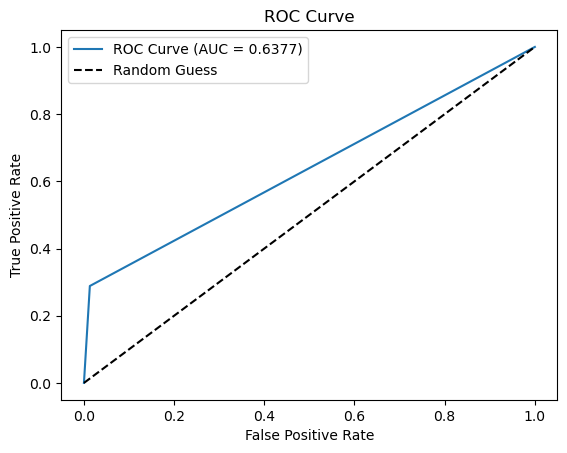

In [162]:
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt


# Extract observed and predicted values
y_true = merged_df["is.included"]
y_pred = merged_df["Decision_binary"]

# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# Calculate precision, recall, and F1
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Calculate AUC (using binary predictions)
auc = roc_auc_score(y_true, y_pred)

# Print results
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

# Optional: Plot ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="best")
plt.show()

In [197]:
import pandas as pd

# Assuming merged_df is already loaded in your environment
df = merged_df  

# Ensure no missing values in key columns
df = df.dropna(subset=["is.included", "Decision_binary"])

# Add a column to flag misalignments
df["Misaligned"] = df["is.included"] != df["Decision_binary"]

# Filter rows where Is.included and Decision_binary differ, including specified columns
# Include 'title' and 'publication_year' if they exist in the dataset
columns_to_include = ["is.included", "Decision_binary"]
if "abstract" in df.columns:
    columns_to_include.append("abstract")
if "title" in df.columns:
    columns_to_include.append("title")
if "publication_year" in df.columns:
    columns_to_include.append("publication_year")

misaligned_cases = df[df["Misaligned"]][columns_to_include]

# Count and categorize misalignments
false_positives = len(df[(df["is.included"] == 0) & (df["Decision_binary"] == 1)])
false_negatives = len(df[(df["is.included"] == 1) & (df["Decision_binary"] == 0)])

# Print summary
print(f"Total misaligned cases: {len(misaligned_cases)}")
print(f"False Positives (Is.included = 0, Decision_binary = 1): {false_positives}")
print(f"False Negatives (Is.included = 1, Decision_binary = 0): {false_negatives}")
print("\nMisaligned cases:")
print(misaligned_cases.to_string(index=True))

# Save misaligned cases to a new file for review
output_path = "merged_df_misaligned_with_details.xlsx"
misaligned_cases.to_excel(output_path, index=True)
print(f"\n✅ Misaligned cases saved to: {output_path}")

Total misaligned cases: 115
False Positives (Is.included = 0, Decision_binary = 1): 4
False Negatives (Is.included = 1, Decision_binary = 0): 111

Misaligned cases:
     is.included  Decision_binary                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [186]:
misalign = pd.read_excel("merged_df_misaligned.xlsx")

In [192]:
misalign 

,Unnamed: 0,is.included,Decision_binary,abstract
0,9,1,0,The article presents information on the Single...
1,12,1,0,Street-involved youth (SY) are a physically an...
2,19,1,0,The current study compares outcomes among youn...
3,21,1,0,Objective: This study examined mental health s...
4,26,1,0,Objective: To develop a food policy approach t...
...,...,...,...,...
110,454,1,0,The third national census of homeless school s...
111,456,1,0,The article offers news briefs on youth in Aus...
112,457,1,0,Newcomer and street-involved youth provided th...
113,460,1,0,NaN


In [95]:
#Structured classification prompt with rule-based reasoning with flexibility to decrease false negative rates
#isn’t classic CoT because it doesn’t demand explicit step-by-step reasoning in the response.
#Temperature 0.5
#have not tested yet

from openai import OpenAI
import pandas as pd
import json
import time

# Initialize the OpenAI client 
client = OpenAI(api_key="INSERT YOUR KEY")

# Load the Excel file
df = pd.read_excel("Phase1_test.xlsx")

def get_decision_for_row(row, row_index):
    study_details = (
        f"Title: {row['title']}\n"
        f"Abstract: {row['abstract']}\n"
        f"Publication Year: {row['publication_year']}\n"
        f"Journal Name: {row['journal_name']}\n"
        f"Author: {row['author']}\n"
        f"Author Affiliation: {row['author_affiliation']}\n"
        f"Keywords: {row['keywords']}"
    )
    
    prompt = f"""
    You are an expert reviewer for research studies with human-like reasoning. Your goal is to identify empirical studies about youth homelessness interventions that should be considered for inclusion. Based on the study details below, the tnterpretation guidance, and the eligibility criteria, decide if the study should be included. Use contextual inference to reduce false negatives (e.g., lean toward 'Yes' when ambiguous but not definitively 'No'). 

    Study Details: {study_details}

    Interpretation Guidance:
    - If a study uses terms like "youth," "adolescents," or "young people," assume the target age is 13–25 unless contradicted.
    - Use 'Publication Year' from the study details as the definitive publication date, ignoring earlier years mentioned in the abstract (e.g., data collection years).
    - If a country isn’t mentioned, assume OECD unless evidence suggests otherwise.
    - If a program/intervention is described with outcomes (e.g., reduced substance use, test scores), assume effectiveness is reported.
    - If the study discusses how the intervention was applied, implemented, or delivered, assume it reports on implementation. To further explain, if the study describes assignment to interventions, group comparisons (e.g., treatment vs. control), or engagement/process details, assume implementation is reported.
    - When eligibility is unclear but aligns with the review’s goal (youth homelessness interventions), lean toward inclusion.


    Eligibility Criteria:
    1. Original or Empirical Research: The study is based on observation and measurement of phenomena using primary data. Secondary data may form the theoretical background. Editorials, letters, and protocols are not included.
    2. Publication Date: Published in 2008 or later.
    3. Target Population (Age): Focuses on youth aged 13–25 (infer from relevant words such as "youth," "adolescents," "young people", etc.).
    4. Target Population (Homelessness): Focuses on youth who are homeless, unstably housed, or at risk of homelessness, including those who: a) are unstably housed, b) have run away from home, c) are currently homeless, or d) are at risk of homelessness (infer from related terms like 'runaway' or 'housing instability').
    5. Geographical Scope: Conducted in an OECD country. OECD countries are: Australia, Austria, Belgium, Canada, Chile, Colombia, Czech Republic, Denmark, Estonia, Finland, France, Germany, Greece, Hungary, Iceland, Ireland, Israel, Italy, Japan, Korea, Latvia, Lithuania, Luxembourg, Mexico, Netherlands, New Zealand, Norway, Poland, Portugal, Slovak Republic, Slovenia, Spain, Sweden, Switzerland, Turkey, United Kingdom, United States (infer from country names, author affiliation, or journal if not explicit. If  If a country is not mentioned, assume it is in the OECD.).
    6. Study Focus: Describes a program, service, or intervention related to youth homelessness (infer from context if not explicit).
    7. Effectiveness Reporting: Reports effectiveness of the program, service, or intervention (infer from outcomes or results if 'effectiveness' isn’t explicit).
    8. Implementation Reporting: Reports implementation of the program, service, or intervention (infer from process descriptions, such as assignment, group design, or process details, if 'implementation' isn’t explicit).

    Exclusion Codes:
    - X-0: Not original/empirical research
    - X-1: Published before 2018
    - X-2: Target population not youth (outside 13–25)
    - X-3: Population not homeless/at risk
    - X-4: Not in an OECD country
    - X-5: No program/service/intervention
    - X-6a: No effectiveness reported
    - X-6b: No implementation reported

    Instructions:
    - Evaluate each criterion holistically, inferring where reasonable (e.g., 'youth' = 13–25).
    - Prioritize 'Publication Year' from study details for criterion 2.
    - Lean toward 'Yes' when a criterion is ambiguous but not definitively unmet, especially for criteria 7 and 8, to reduce false negatives.
    - Return:
      1. "Criteria_Results": List of 8 answers ("Yes" or "No (X-code)")
      2. "Decision": "Yes" if all criteria are "Yes", "No" if any are "No"
      3. "Explanation": "N/A" for Yes, list of codes for No
    - Return only the JSON object.
    """

    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "You are an expert reviewer with human-like reasoning."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.5  # Could be slightly higher for flexibility while maintaining consistency
        )
        reply = response.choices[0].message.content.strip()
        # Clean markdown-style backticks
        if reply.startswith("```json"):
            reply = reply.replace("```json", "").strip("` \n")
        elif reply.startswith("```"):
            reply = reply.strip("` \n")
        
        try:
            result = json.loads(reply)
            return (
                result.get("Decision", "No"),  # Default to "No" if parsing fails
                result.get("Explanation", "Parse error"),
                result.get("Criteria_Results", [])
            )
        except json.JSONDecodeError:
            print(f"⚠️ JSON parse error on row {row_index + 1}")
            print("GPT Reply:\n", reply)
            return "No", "Parse error", []
    except Exception as e:
        print(f"❌ Error on row {row_index + 1}: {e}")
        return "No", "API error", []

# Process all rows
decisions = []
explanations = []
criteria_logs = []
for i, row in df.iterrows():
    decision, explanation, criteria = get_decision_for_row(row, i)
    decisions.append(decision)
    explanations.append(explanation)
    criteria_logs.append(str(criteria))
    time.sleep(1)  # Respect API rate limits

# Add results to DataFrame
df["Decision"] = decisions
df["Explanation"] = explanations
df["Criteria_Results"] = criteria_logs

# Save the results
output_path = "Phase1_with_FNreduction_temp0.5.xlsx"
df.to_excel(output_path, index=False)
print(f"\n✅ Processing complete. File saved to: {output_path}")



✅ Processing complete. File saved to: Phase1_with_FNreduction_temp0.5.xlsx


In [99]:
temp05 = pd.read_excel("Phase1_with_FNreduction_temp0.5.xlsx")

In [103]:
temp05['Decision'].value_counts()

Decision
No     13
Yes     6
Name: count, dtype: int64

In [105]:
temp05

,title,publication_year,abstract,journal_name,publisher,author,author_affiliation,keywords,Decision,Explanation,Criteria_Results
0,Comparison Of Family Therapy Outcome With Alco...,2009,"Treatment evaluation for alcohol problem, runa...",Journal of marital and family therapy,NIH Public Access,"Natasha Slesnick, Jillian Prestopnik","Ohio State University, The University of New M...","adolescents, runaways, family therapy, alcohol...",Yes,NaN,"['Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Ye..."
1,Intervention With Substance-Abusing Runaway Ad...,2013,Objectives\nTo examine the efficacy of three t...,Journal of consulting and clinical psychology,"Washington, DC: American Psychological Associa...","Natasha Slesnick, Gizem Erdem, Suzanne Bartle-...",Department of Human Sciences at the Ohio State...,"runaway adolescents, substance abuse treatment...",Yes,NaN,"['Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Ye..."
2,Implementing A Psychologically Informed Enviro...,2014,Purpose\n- The purpose of this paper is to des...,"Housing, Care and Support",Brighton: Emerald Group Publishing Limited,"Jeremy Woodcock, Jamie Gill",Dr Jeremy Woodcock is a Consultant Psychothera...,"Homeless, Young people, Learning organization,...",No,"X-0, X-6a","['No (X-0)', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes'..."
3,Evaluation Of Harsh Reality: A Sexual Health P...,2013,Introduction: Street-involved youth are one of...,Health Education Journal,"London, England: SAGE Publications","Chelsea Jalloh, Barbara McMillan, Margaret Orm...",Department of Curriculum Teaching and Learning...,"Street-involved youth, sexually transmitted in...",Yes,NaN,"['Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Ye..."
4,"Necessary, But Not Sufficient: The Mckinney-Ve...",2012,The McKinney–Vento Homeless Education Assistan...,Children & Schools,Oxford: Oxford University Press,"George Hendricks, William Barkley",School of Social Work at Methodist University ...,academic achievement; end-of-grade test scores...,Yes,NaN,"['Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Ye..."
5,Sroi In The Pay For Success Context: Are They ...,2017,The Pay For Success (PFS) and Social Impact Bo...,Evaluation and Program Planning,New York: Elsevier Ltd,"Robert L. Fischer, Francisca García-Cobián Ric...","Case Western Reserve University Jack Joseph, M...","Social return on investment, pay for success",No,"['X-0', 'X-2', 'X-3', 'X-5', 'X-6a', 'X-6b']","['No (X-0)', 'Yes', 'No (X-2)', 'No (X-3)', 'Y..."
6,Interventions For Promoting Reintegration And ...,2013,Background Millions of street‐connected childr...,Cochrane Database of Systematic Reviews,"Chichester, UK: John Wiley & Sons, Ltd","Esther Coren, Rosa Hossain, Jordi Pardo Pardo,...",School of Public Health Midwifery and Social W...,NaN,No,X-0,"['No (X-0)', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes'..."
7,Systematic Review Of Barriers And Facilitators...,2016,Introduction This study aims to review the lit...,Asia-Pacific Psychiatry,Australia: Blackwell Publishing Ltd,"Adrienne Brown, Simon M. Rice, Debra J. Rickwo...",Headspace Centre of Excellence in Youth Mental...,"adolescence, early intervention, mental health...",No,"X-0, X-5, X-6a, X-6b","['No (X-0)', 'Yes', 'Yes', 'Yes', 'Yes', 'No (..."
8,Prevention Case Management Improves Socioecono...,2012,Urban transgender women often experience sever...,AIDS Care,Abingdon: Taylor & Francis Group,"Cathy J. Rebacka, Steven Shoptawc, Martin J. D...","Friends Research Institute, Inc., Los Angeles,...",transgender women; prevention case management;...,No,X-2,"['Yes', 'Yes', 'No (X-2)', 'Yes', 'Yes', 'Yes'..."
9,Outreach With Street-Involved Youth: A Quantit...,2012,Outreach workers meet with street-involved you...,Clinical Psychology Review,United States: Elsevier Ltd,"J.A. Connolly, L.E. Joly","York University, 5022 TEL, 4700 Keele St., Tor...",Street-involved; Homeless; Youth; Outreach; Me...,No,X-0,"['No (X-0)', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes'..."
